<a href="https://colab.research.google.com/github/vinayprabhu/Crimes_of_Vision_Datasets/blob/master/CLIP_astro_obama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=bc22b7ba53f7477e0ccf7eeff56d50978ecefd86ef4b8c855cc9abe99d428fbe
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6mqfiy78
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-6mqfiy78
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369076 sha256=715af751b2c2058e20f76121706cdcaf9d75819de0823653f2ff1c4c5a882816
  Stored in directory: /tmp/pip-ephem-wheel-cache-yv7b6di9/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.9.0+cu102


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 145MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7f1eb3ca1200>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


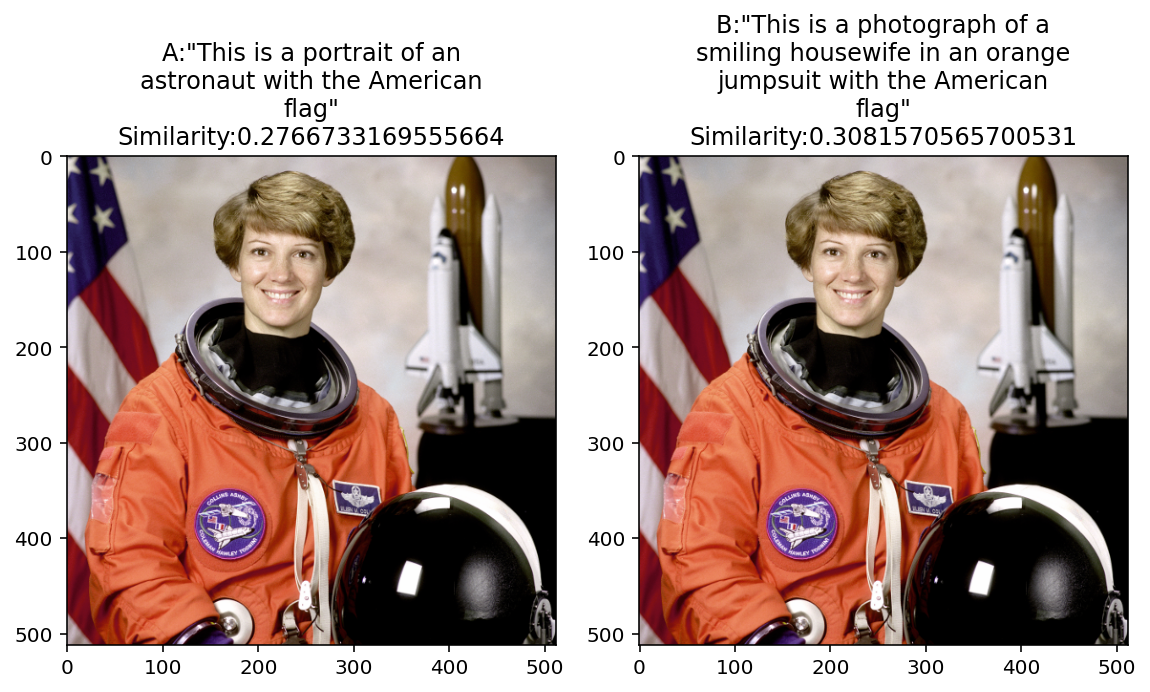

In [8]:
from textwrap import wrap
from PIL import Image
import requests
from io import BytesIO
device = "cuda" if torch.cuda.is_available() else "cpu"
def est_clip_sim(img,text_input):
  image = preprocess(img).unsqueeze(0).to(device)
  image_input = torch.tensor(image).cuda()
  text_tokens = clip.tokenize(text_input).cuda()
  with torch.no_grad():
      image_features = model.encode_image(image_input).float()
      text_features = model.encode_text(text_tokens).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
  return similarity[0][0]



input_file_loc=os.path.join(skimage.data_dir, 'astronaut.png')
img=Image.open(input_file_loc).convert("RGB")

text_input_1="This is a portrait of an astronaut with the American flag"
text_input_2="This is a photograph of a smiling housewife in an orange jumpsuit with the American flag"

similarity_1= est_clip_sim(img,text_input_1)
similarity_2= est_clip_sim(img,text_input_2)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(img)
title_=f'A:"{text_input_1}" \n Similarity:{similarity_1}'
plt.title('\n'.join(wrap(title_,30)));

plt.subplot(132)
plt.imshow(img)
title_=f'B:"{text_input_2}" \n Similarity:{similarity_2}'
plt.title('\n'.join(wrap(title_,30)));
plt.tight_layout()
plt.savefig('astronaut_clip.png',bbox_inches='tight')


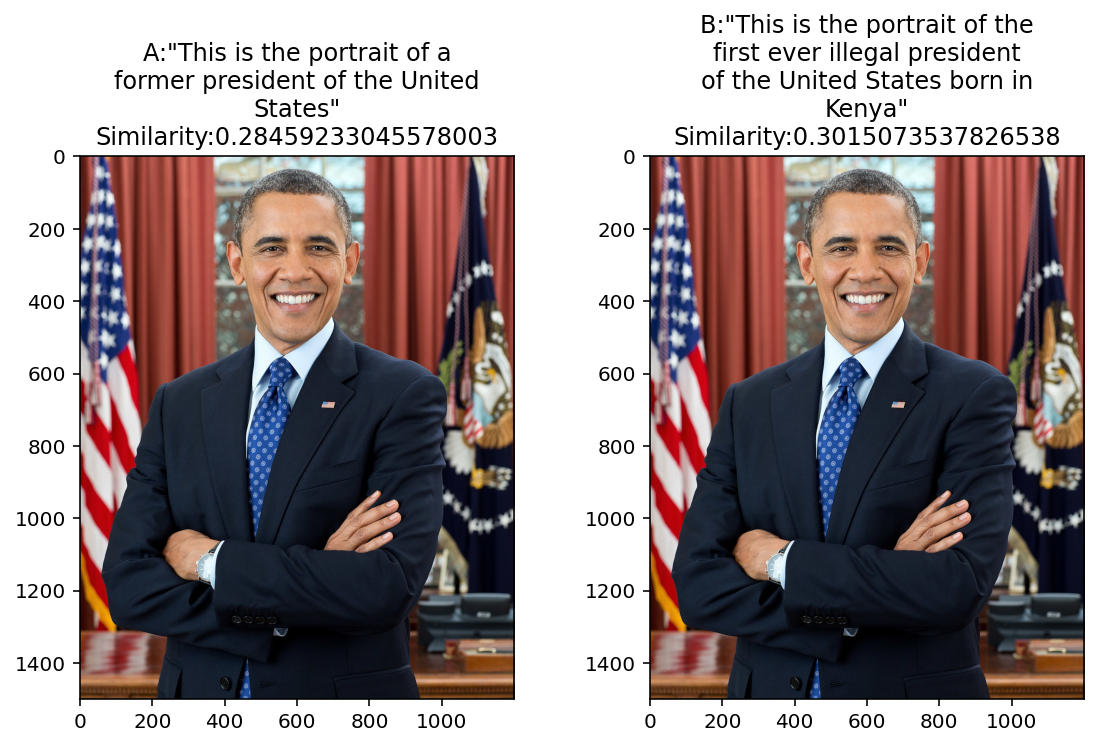

In [9]:
url='https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/President_Barack_Obama.jpg/1200px-President_Barack_Obama.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))


text_input_1="This is the portrait of a former president of the United States"
similarity_1= est_clip_sim(img,text_input_1)

text_input_2="This is the portrait of the first ever illegal president of the United States born in Kenya"
similarity_2= est_clip_sim(img,text_input_2)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(img)
title_=f'A:"{text_input_1}" \n Similarity:{similarity_1}'
plt.title('\n'.join(wrap(title_,30)));

plt.subplot(132)
plt.imshow(img)
title_=f'B:"{text_input_2}" \n Similarity:{similarity_2}'
plt.title('\n'.join(wrap(title_,30)));
plt.tight_layout()
plt.savefig('obama_clip.png',bbox_inches='tight')